### DEMDP01 
# Timber Harvesting Model - Cubic Spline Approximation

Profit maximizing owner of a commercial tree stand must decide when to clearcut the stand.

In [1]:
%matplotlib inline
from warnings import simplefilter
simplefilter('ignore')
from compecon import DPmodel, BasisSpline
from demos.setup import np, plt, demo


### Model Parameters
Assuming that the unit price of biomass is $p=1$, the cost to clearcut-replant is $\kappa=0.2$, the stand carrying capacity $s_{\max}=0.5$, biomass growth factor is $\gamma=10\%$ per period, and the annual discount factor $\delta=0.9$.

In [2]:
price = 1.0
kappa = 0.2
smax  = 0.5
gamma = 0.1
delta = 0.9

### State Space
The state variable is the stand biomass, $s\in [0,s_{\max}]$.  

Here, we represent it with a cubic spline basis, with $n=200$ nodes.


In [3]:
n = 200
basis = BasisSpline(n, 0, smax, 
                    labels=['biomass'])

### Action Space
The action variable is $j\in\{0:\text{'keep'},\quad 1:\text{'clear cut'}\}$.


### Reward function
If the farmer clears the stand, the profit is the value of selling the biomass $ps$ minus the cost of clearing and replanting $\kappa$, otherwise the profit is zero.

In [4]:
def reward(s, x, i , j):
    return (price * s - kappa) * j

### State Transition Function
If the farmer clears the stand, it begins next period with $\gamma s_{\max}$ units. If he keeps the stand, then it grows to $s + \gamma (s_{\max} - s)$.


In [5]:
def transition(s, x, i, j, in_, e):
    if j:
        return np.full_like(s, gamma * smax)
    else:
        return s + gamma * (smax - s)

### Model Structure
The value of the stand, given that it contains $s$ units of biomass at the beginning of the period, satisfies the Bellman equation

\begin{equation} V(s) = \max\left\{(ps-\kappa) + \delta V(\gamma s_{\max}),\quad \delta V[s+\gamma(s_{\max}-s)]  \right\}   \end{equation}

To solve and simulate this model, use the CompEcon class ```DPmodel```.

In [6]:
model = DPmodel(basis, reward, transition,
                discount=delta,
                j=['keep', 'clear-cut'])

S = model.solve()

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       3.1e-01    0.0100
   1       1.1e-01    0.0180
   2       1.1e-02    0.0260
   3       4.6e-03    0.0325
   4       1.9e-16    0.0405
Elapsed Time =    0.04 Seconds


The ```solve``` method retuns a pandas ```DataFrame```, which can easily be used with the ggplot package.

## Analysis

### Plot the Value Function

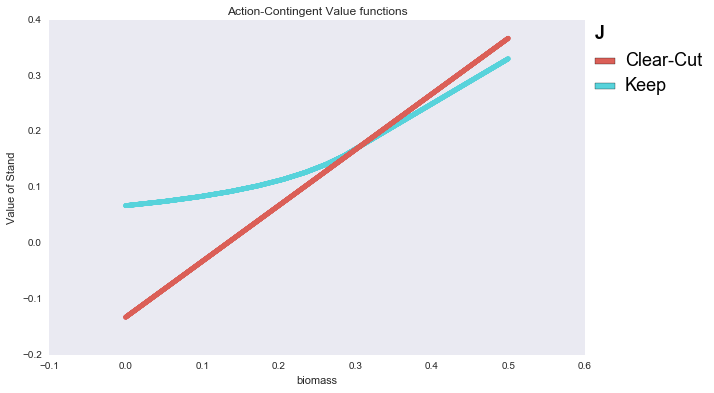

<ggplot: (152050177505)>

In [7]:
demo.qplot('biomass', 'value_j','j',
      data=S,
      main='Action-Contingent Value functions',
      ylab='Value of Stand'
     )

### Plot Residuals

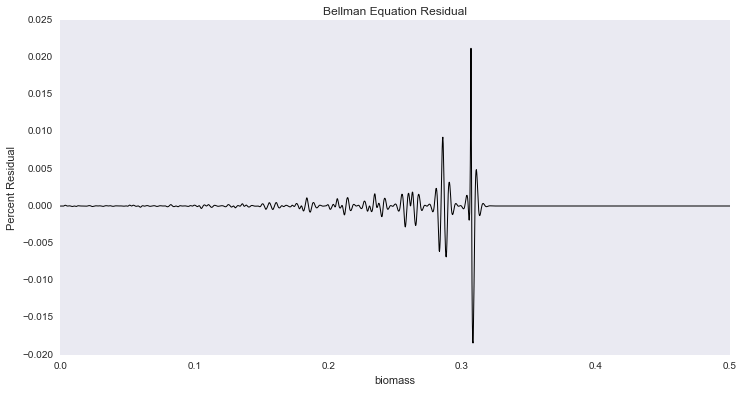

<ggplot: (152050202323)>

In [8]:
S['resid2'] = 100*S.resid / S.value

demo.qplot('biomass', 'resid2',
      data=S,
      geom='line',
      main='Bellman Equation Residual',
      ylab='Percent Residual'
     )

###  Simulation

The path followed by the biomass is computed by the ```simulate()``` method. Here we simulate 31 periods starting with a biomass level $s_0 = 0$.

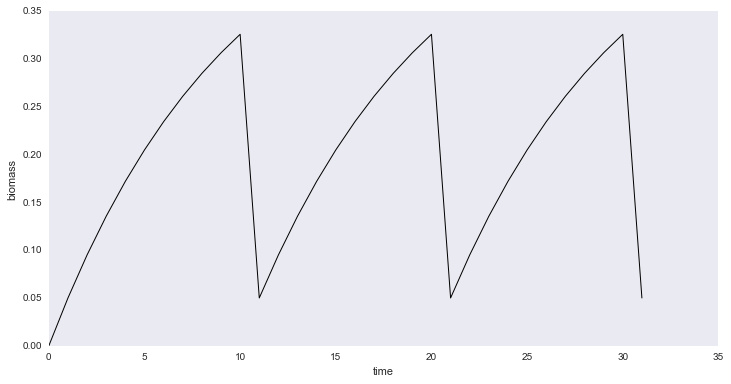

<ggplot: (-9223371884804430041)>

In [9]:
H = model.simulate(31, 0.0)
demo.qplot('time','biomass',geom='line', data=H)